In [ ]:
import pandas as pd
import numpy as np

# Đọc dữ liệu
df_train = pd.read_csv('/content/df_train_clean.csv')
df_dev   = pd.read_csv('/content/df_dev_clean.csv')
df_test  = pd.read_csv('/content/df_test_clean.csv')

# Định nghĩa nhãn
emotions = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Fear', 'Surprise', 'Other']
label2id = {e: i for i, e in enumerate(emotions)}
id2label = {i: e for i, e in enumerate(emotions)}

In [ ]:
for df in (df_train, df_dev, df_test):
    if 'label_id' not in df:
        if 'Emotion' in df:
            df['label_id'] = df['Emotion'].map(label2id)
        elif 'label' in df:
            df['label_id'] = df['label'].map(label2id)
    df['content_clean'] = df['content_clean'].fillna('').astype(str)

In [ ]:
X_train = df_train['content_clean'].tolist()
y_train = df_train['label_id'].astype(int).to_numpy()
X_dev   = df_dev['content_clean'].tolist()
y_dev   = df_dev['label_id'].astype(int).to_numpy()
X_test  = df_test['content_clean'].tolist()
y_test  = df_test['label_id'].astype(int).to_numpy()
num_classes = len(emotions)

In [ ]:
df_train

,Unnamed: 0,Emotion,content,content_clean,label_id
0,188,Other,cho mình xin bài nhạc tên là gì với ạ,cho mình xin bài nhạc tên là gì với ạ,6
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,1
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,lo học đi . yêu đương lồn gì hay lại thích học...,1
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),uớc gì sau này về già vẫn có thể như cụ này ☺️,0
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,mỗi lần có video của con là cứ coi đi coi lại ...,0
...,...,...,...,...,...
5543,1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,1
5544,825,Other,nhìn mặt héo queo luôn,nhìn mặt héo queo luôn,6
5545,165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,6
5546,363,Enjoyment,thích thân hình boss rồi nhan 😌,thích thân hình boss rồi nhan 😌,0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

max_seq_len = 80
X_train_ids = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_seq_len, padding='post')
X_dev_ids   = pad_sequences(tokenizer.texts_to_sequences(X_dev),   maxlen=max_seq_len, padding='post')
X_test_ids  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=max_seq_len, padding='post')

# One-hot cho label
y_train_cat = to_categorical(y_train, num_classes)
y_dev_cat   = to_categorical(y_dev, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.models import Model

embedding_dim = 128

inp = Input(shape=(max_seq_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(inp)
x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2))(x)
x = MaxPooling1D(pool_size=2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 80, 128)        │       546,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,351 (2.39 MB)

 Trainable params: 627,351 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_ids, y_train_cat,
    validation_data=(X_dev_ids, y_dev_cat),
    batch_size=32,
    epochs=10,        # Bạn có thể dừng sớm khi overfit
    verbose=1
)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.2575 - loss: 1.8369 - val_accuracy: 0.4344 - val_loss: 1.5277
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - accuracy: 0.4815 - loss: 1.3922 - val_accuracy: 0.5262 - val_loss: 1.2639
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 140ms/step - accuracy: 0.6604 - loss: 0.9647 - val_accuracy: 0.5612 - val_loss: 1.1972
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 39s 130ms/step - accuracy: 0.7595 - loss: 0.7223 - val_accuracy: 0.5598 - val_loss: 1.2547
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.8155 - loss: 0.5468 - val_accuracy: 0.5554 - val_loss: 1.3821
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 44s 151ms/step - accuracy: 0.8707 - loss: 0.4051 - val_accuracy: 0.5364 - val_loss: 1.5762
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - accuracy: 0.9034 - loss: 0.2982 - val_accuracy: 0.5408 - val_loss: 1.7417
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 48s 173ms/step - accuracy: 0.9225 - loss: 0

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
              precision    recall  f1-score   support

   Enjoyment     0.6108    0.6425    0.6263       193
     Disgust     0.5038    0.5000    0.5019       132
     Sadness     0.5882    0.5172    0.5505       116
       Anger     0.4390    0.4500    0.4444        40
        Fear     0.6429    0.5870    0.6136        46
    Surprise     0.4211    0.4324    0.4267        37
       Other     0.4118    0.4341    0.4226       129

    accuracy                         0.5296       693
   macro avg     0.5168    0.5090    0.5123       693
weighted avg     0.5317    0.5296    0.5300       693



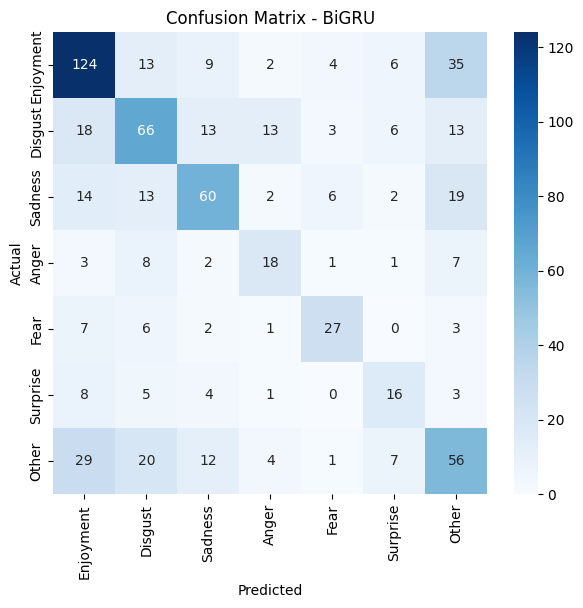

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_ids, batch_size=32)
y_pred_cls = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_cls, target_names=emotions, digits=4))
cm = confusion_matrix(y_test, y_pred_cls)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BiGRU")
plt.show()